# UCOOT Tutorial

In this tutorial, we will examine how to use Co-Optimal Transport (COOT) and Unbalanced Co-Optimal Transport (UCOOT) to align a CITE-seq dataset, which contains co-assayed gene expression and antibody data on 1000 human blood cells (subsetted from a dataset of 7985 human/mouse blood cells). We will split this dataset into gene expression data and antibody data in hopes that UCOOT will be able to recover which samples match in the full dataset (same goal as in UGW).

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you are unsure how to initialize a Solver object, view our setup tutorial to get a sense for how to trade speed and accuracy using its constructor parameters.

If the notation and problem formulation seem confusing, try viewing our document on the theory of optimal transport to get more comfortable first.

If you want a more gradual intro into this tool, start with our UGW tutorial.

If you are already comfortable with UCOOT, try moving on to our fused formulation tutorial or our AGW tutorial.
```

### Data Download

We provide preprocessed data on the 1000 cells we will be working with. However, if you would like to do the preprocessing yourself (for example, following the steps in Tran et al.) and do not already have the PBMC_ADT and PBMC_RNA files downloaded from the CITE-seq dataset, run the following commands in the terminal in the root directory of this tutorial repository:

<center> sh ./download_scripts/CITEseq_download.sh </center>

If you have not modified our original directory structure for the data, these files will be dropped into the same folder as the preprocessed datasets.

### Preprocessing

We will start with some mild preprocessing, such as loading the preprocessed datasets into variables local to this notebook. We begin by setting up pytorch. Use this as is, unless you would like to try a different device.

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


As in the UGW tutorial, we omit our exact preprocessing steps and move directly towards alignment. If you are curious to do your own preprocessing, we recommend doing it here, as well as trying to keep your final variable names consistent with ours.

In [57]:
%%capture
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, FOSCTTM
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]

# note that the two PTPRC columns are exactly equal; PTPRC is associated with both CD45RA and CD45RO
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]


```{note}
As in the UGW tutorial, we examine 25 gene-antibody pairs. Note that we line up pairs along the diagonal of our feature coupling matrices, such that a diagonal feature coupling matrix perfectly uncovers each gene-antibody relationship.
```

In [58]:
# l2 normalization of both datasets, which we found to help with single cell applications
adt = pd.DataFrame(normalize(adt_raw.X.transpose()))
rna = pd.DataFrame(normalize(rna_raw.X.transpose()))

# annotation of both domains
adt.index, adt.columns = samp_labels, adt_feat_labels
rna.index, rna.columns = samp_labels, rna_feat_labels

Now that we have our two matrices ready, we can remind ourselves what the original domains looked like in the UGW tutorial.

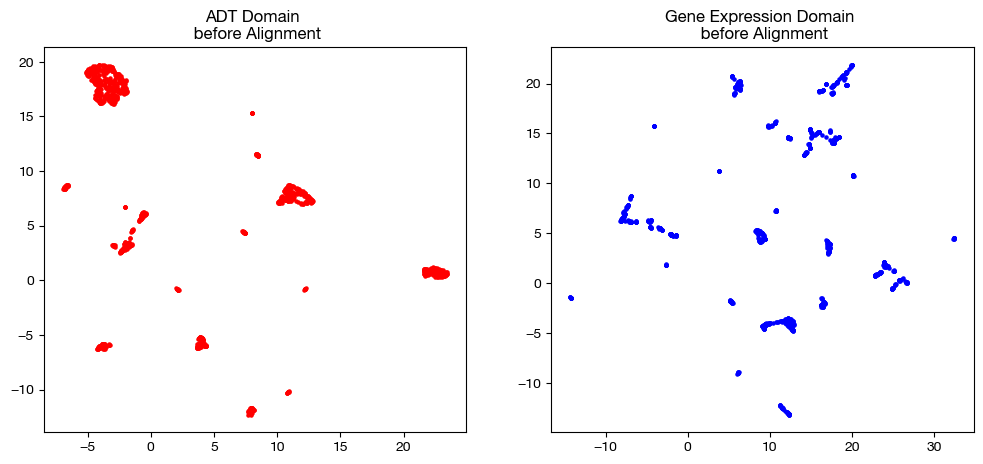

In [4]:
# we fit these objects now, and use them to transform our aligned data later on
adt_um = umap.UMAP(random_state=0, n_jobs=1)
rna_um = umap.UMAP(random_state=0, n_jobs=1)

adt_um.fit(adt.to_numpy())
rna_um.fit(rna.to_numpy())

original_adt_um=adt_um.transform(adt.to_numpy())
original_rna_um=rna_um.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(original_rna_um[:,0], original_rna_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

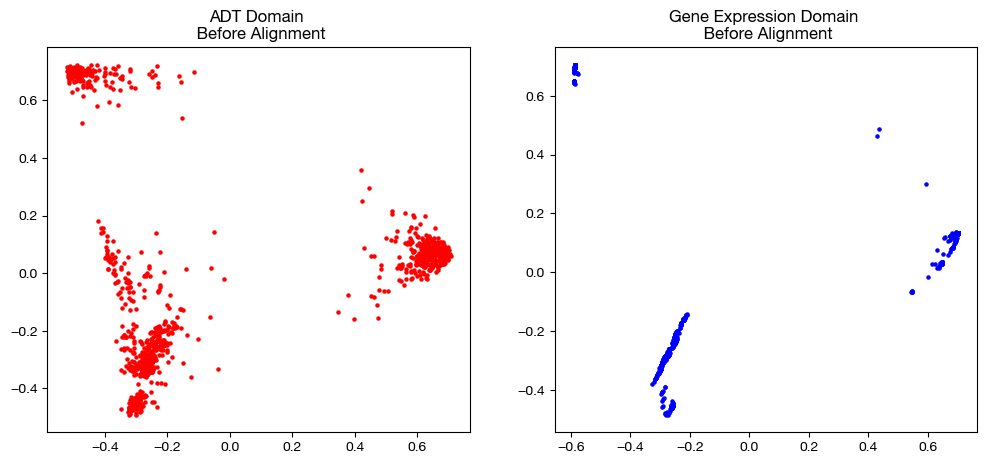

In [5]:
from sklearn.decomposition import PCA

# again, we fit these now so that we can transform our aligned data later on
adt_pca=PCA(n_components=2)
rna_pca=PCA(n_components=2)

adt_pca.fit(adt.to_numpy())
rna_pca.fit(rna.to_numpy())

original_adt_pca=adt_pca.transform(adt.to_numpy())
original_rna_pca=rna_pca.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n Before Alignment")
ax2.scatter(original_rna_pca[:,0], original_rna_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n Before Alignment")
plt.show()

### Default COOT

With the data loaded and preprocessed, we can begin by instantiating a Solver object.

In [6]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3, device=device)

From here, we can begin solving our UCOOT problem. For now, we'll focused on the balanced variant of UCOOT, COOT. Note that both COOT and UCOOT align both samples and features between two datasets that share an underlying manifold. In order to have the flexibility to do this, both formulations have a number of hyperparameters, which we will examine over the course of this tutorial. 

Before we start looking at results, let's remember what exactly COOT seeks to do. Unlike GW, COOT simultaneously aligns samples and features and does not consider pairwise distances directly. Instead, for all sample-feature pairs ($i, j$) in $X$ and pairs ($k, l$) in $Y$ (these pairs identify a particular entry in one of these matrices of data), COOT seeks to minimize the following transport cost (minus the regularizing terms, for now):

$L(X_{ij}, Y_{kl}) \cdot \pi_{s_{ik}} \cdot \pi_{f_{jl}}$

Where $L$ is some function that defines the cost of matching $X_{ij}$ to $Y_{kl}$, $\pi_s$ (or $P$) is the sample coupling matrix, and $\pi_f$ (or $Q$) is the feature coupling matrix. In our case, $L$ will be squared euclidean distance. Intuitively, this cost function indicates that COOT will encourage matching samples $i$ and $k$ that have values for features $j$, $l$ that are similar with respect to the other samples of their respective domains. As you might be able to tell, this encouragment leads to some circular logic; this dependency of feature coupling on sample coupling allows the matrices to converge to minimize the above cost function. In relation to GW, COOT encourages matching samples that are similar relative to the features of their respective domains, rather than the other samples (as in GW). 

Let's try using the COOT solver with its default parameters to see how the procedure works. In this first section, we will also go over how to score and project data using solved COOT coupling matrices. Like in the UGW tutorial, we'll override the early stopping tolerance (see setup tutorial) to speed up our initial attempts.

In [7]:
# set verbose=True to get a breakdown of the cost progression during optimization
# set log=True to get extra return values, log_cost and log_ent_cost, which display the cost progression
(pi_samp, _, pi_feat), _, log_ent_cost = scot.coot(rna, adt, verbose=False, log=True, eps=1e-3, early_stopping_tol=1e-4)

Notice how the solver we used returns a tuple of coupling matrices, the vectors resulting from the Sinkhorn algorithm used to generate these coupling matrices, and two logs of the cost progression (same as UGW). The first matrix in the tuple returned is the coupling matrix for samples, while the second matrix returned is the coupling matrix for features. From here, we use the first matrix to project the gene expression data samples into the domain of the ADT samples:

In [8]:
aligned_rna = get_barycentre(adt, pi_samp)
aligned_rna.numpy().shape

(1000, 25)

```{warning}
In this projection step, be careful how you use X and Y. Whichever matrix you entered first (call this Y) in the original alignment will have its samples on the vertical axis of pi_samp, meaning that calling get_barycentre(X, pi_samp) will project the other matrix, Y, into the feature-space of X. See the UGW tutorial for a bit more detail.
```

Note that these coupling matrices have value in their own right – we can use them to understand the relationships between samples or features based on how much mass is transported from a sample/feature in one domain to a sample/feature in the other. Considering we tend to get a good picture of the sample alignment after projection in our UMAPs/PCAs, we focus on the feature coupling matrices in these heatmaps.

<Axes: >

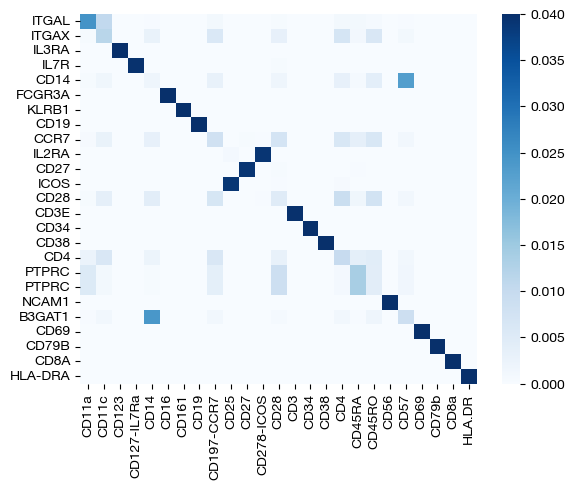

In [9]:
import seaborn as sns

sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), cmap='Blues')

With our newly aligned data, which contains estimated ADT data on the samples from the gene expression data, we can do a few things. First, we can score how good the alignment is using the FOSCTTM metric we discussed in the UGW tutorial.

Average FOSCTTM score for this alignment with X onto Y is: 0.0771936936936937


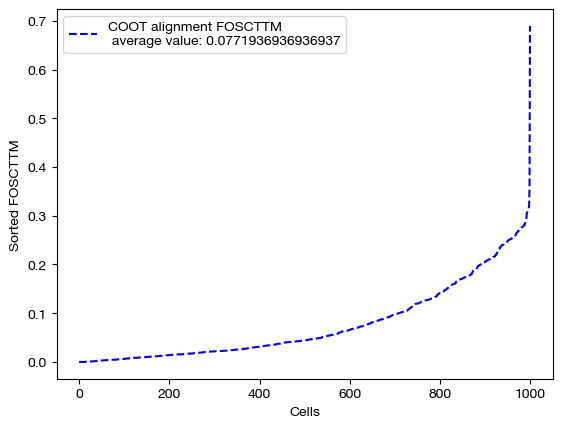

In [10]:
fracs = FOSCTTM(adt, aligned_rna.numpy())
print("Average FOSCTTM score for this alignment with X onto Y is:", np.mean(fracs))
legend_label="COOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

The closer the FOSCTTM is to 0, and the more convex this curve above, the better the alignment is. Note that a metric like FOSCTTM cannot be applied to data without a known, underlying 1-1 mapping. For these cases, we use something called label transfer accuracy, which we will examine in our applications notebooks.

From here, we can visualize the data, again with UMAP and PCA:

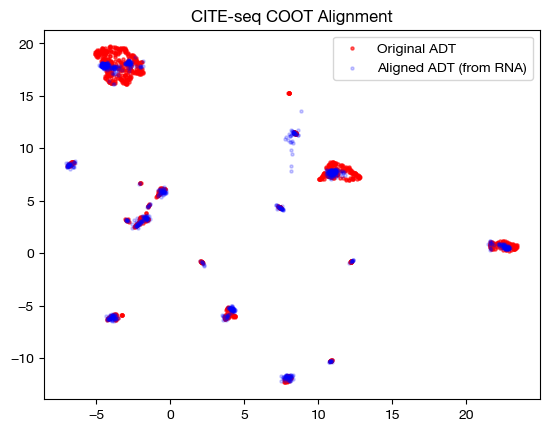

In [11]:
# fit on original two components
original_adt_um=adt_um.transform(adt)
aligned_rna_um=adt_um.transform(aligned_rna.numpy())

plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq COOT Alignment")
plt.show()

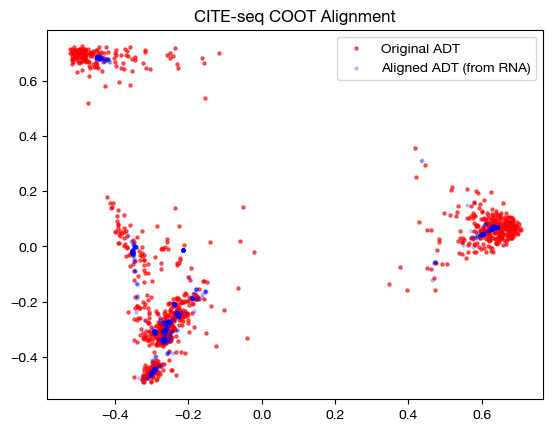

In [12]:
# fit on original two components
original_adt_pca=adt_pca.transform(adt.to_numpy())
aligned_rna_pca=adt_pca.transform(aligned_rna.numpy())

plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq COOT Alignment")
plt.show()

### Entropic Regularization

With this example under our belt, let's try playing around with some of the different modes and hyperparameters.

First, we will experiment with $\epsilon$. The $\epsilon$ parameter changes the weight of the entropy term, which we add to the transport cost term discussed above when minimizing cost and optimizing our two coupling matrices. The more weight the entropy term has, the more entropy we will see in the final convergence of the COOT algorithm. This means that the resulting coupling matrices for both samples and features will be more dense (further away from 1-1 alignment). However, a higher value of $\epsilon$ makes the COOT algorithm converge faster. As a result, $\epsilon$ serves as a tradeoff between speed and precision, at least to some extent. Let's compare three values: a reasonable $\epsilon$ value for this data, a large $\epsilon$ value, and a small $\epsilon$ value. Note that this is performed with independent entropic regularization (we will go over joint later).

In [13]:
import time

start = time.time()
(pi_samp_small, _, pi_feat_small), _, log_ent_cost = scot.coot(rna, adt, eps=1e-4, log=True, verbose=False)
end = time.time()

print(f"Time for low epsilon: {(end - start):0.2f} seconds")

start = time.time()
(pi_samp_med, _, pi_feat_med), _, log_ent_cost = scot.coot(rna, adt, eps=1e-3, log=True, verbose=False)
end = time.time()

print(f"Time for medium epsilon: {(end - start):0.2f} seconds")

start = time.time()
(pi_samp_lg, _, pi_feat_lg), _, log_ent_cost = scot.coot(rna, adt, eps=1e-1, log=True, verbose=False)
end = time.time()

print(f"Time for high epsilon: {(end - start):0.2f} seconds")

Time for low epsilon: 63.46 seconds
Time for medium epsilon: 36.79 seconds
Time for high epsilon: 0.09 seconds


Note how, in the above alignments, the timing gets faster from a very small $\epsilon$ to higher $\epsilon$. Now, let's align the data and examine the FOSCTTM scores for each alignment:

In [14]:
aligned_rna_sm = get_barycentre(adt, pi_samp_small)
aligned_rna_med = get_barycentre(adt, pi_samp_med)
aligned_rna_lg = get_barycentre(adt, pi_samp_lg)

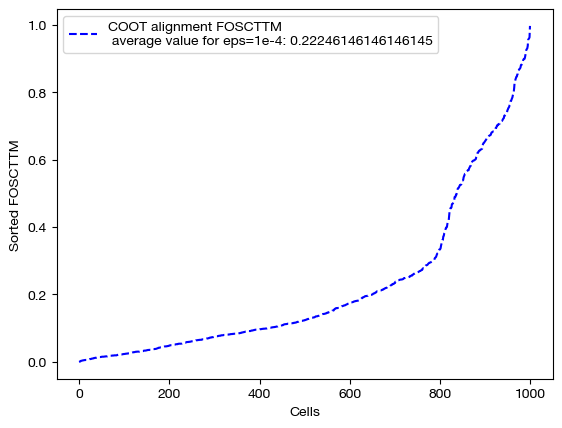

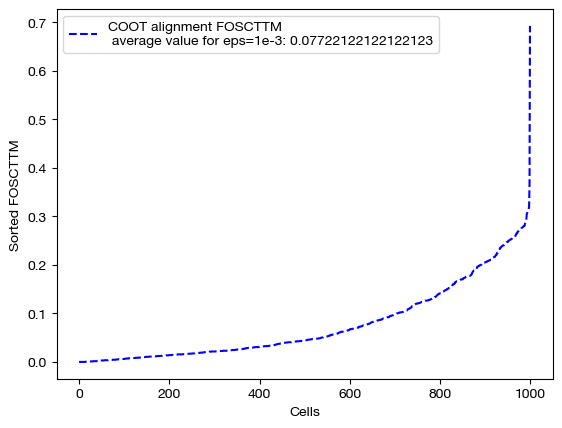

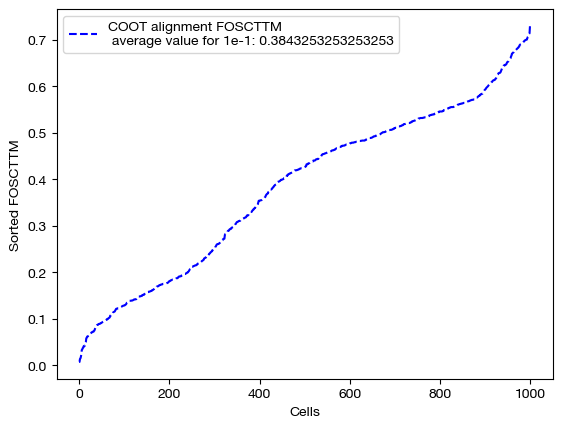

In [15]:
for aligned_rna, size in [(aligned_rna_sm, 'eps=1e-4'), (aligned_rna_med, 'eps=1e-3'), (aligned_rna_lg, '1e-1')]:
    fracs = FOSCTTM(adt, aligned_rna.numpy())
    legend_label="COOT alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

As seen above, decreasing $\epsilon$ is not a surefire way to improve alignment quality. Try experimenting with a wide range of $\epsilon$ to find the best $\epsilon$ for your data:

In [16]:
# an example of epsilon search
pi_samp_dt = {}
pi_feat_dt = {}
# for val in np.logspace(start=-4, stop=-1, num=10):
    # pi_samp_dt[val], _, pi_feat_dt[val] = scot.coot(X, Y, eps=val)

To wrap up our investigation of $\epsilon$, let's visualize the results from our three different $\epsilon$ values. We will begin by looking at the coupling matrices from our alignments:

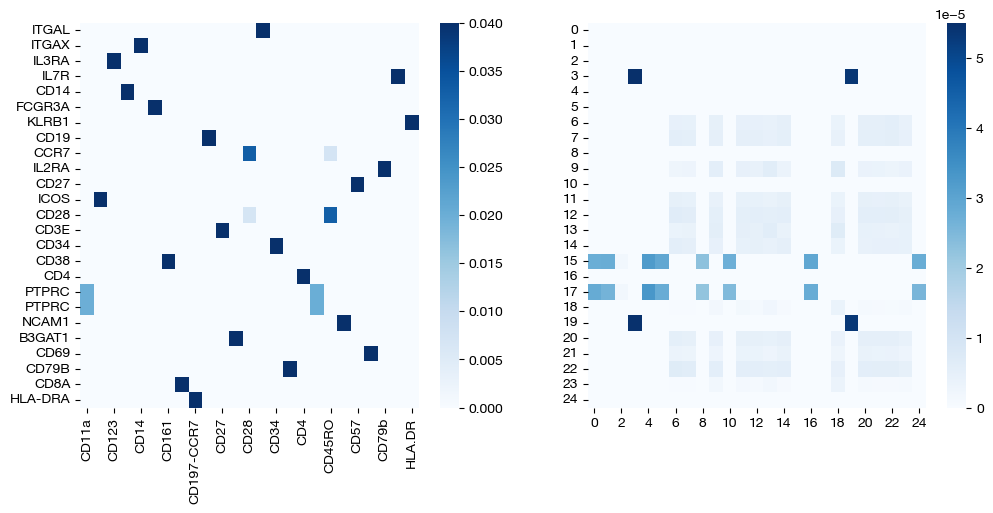

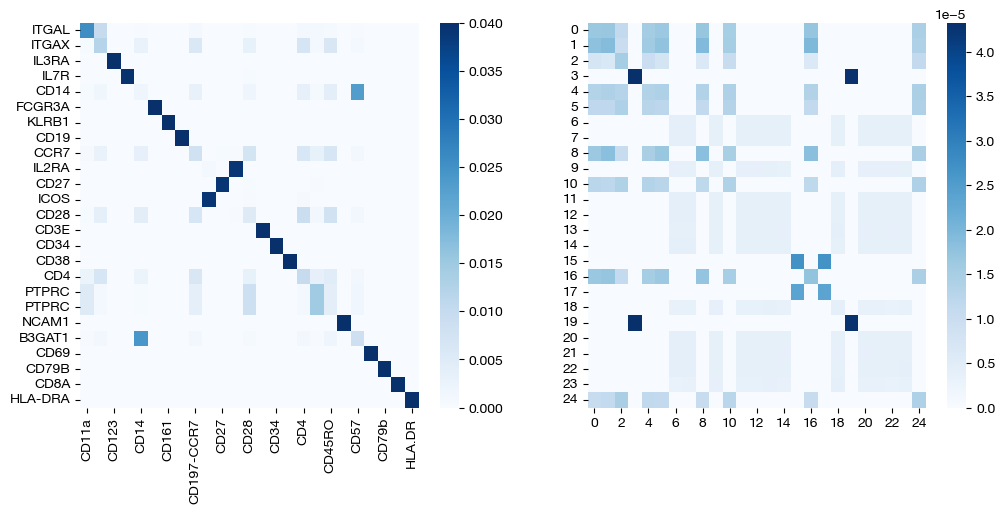

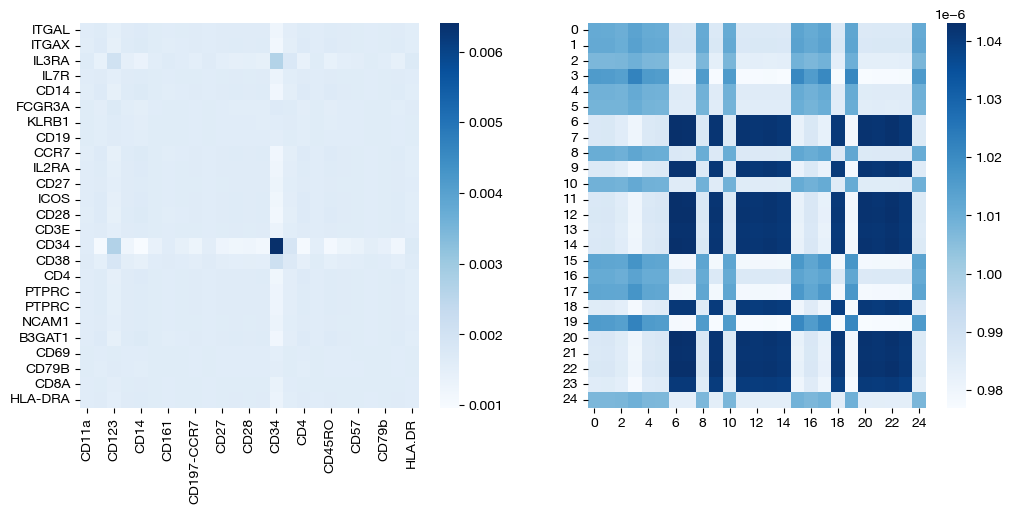

In [17]:
for pi_feat, pi_samp, size in [(pi_feat_small, pi_samp_small, 'eps=1e-4'), (pi_feat_med, pi_samp_med, 'eps=1e-3'), (pi_feat_lg, pi_samp_lg, 'eps=1e-1')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), ax=ax1, cmap='Blues')
    
    # looking at a corner to get a sense for the density
    sns.heatmap(pi_samp[:25, :25], ax=ax2, cmap='Blues')
    plt.show()

Note that the first two pairs of coupling matrices are quite sparse, but for the largest value of $\epsilon$, the coupling matrices are very dense. This result fits with what we expected when we first introduced $\epsilon$ earlier. Now, we can look at the UMAPs to get a sense for what this means with regards to alignment.

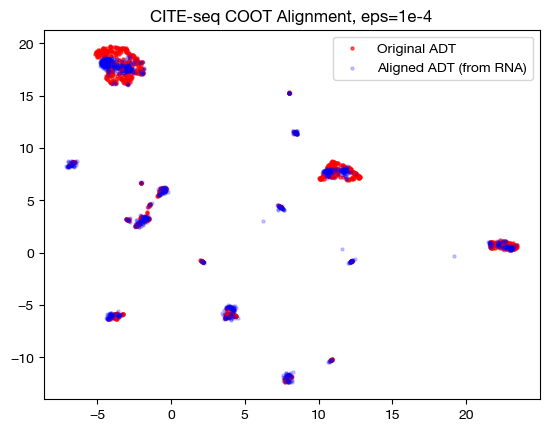

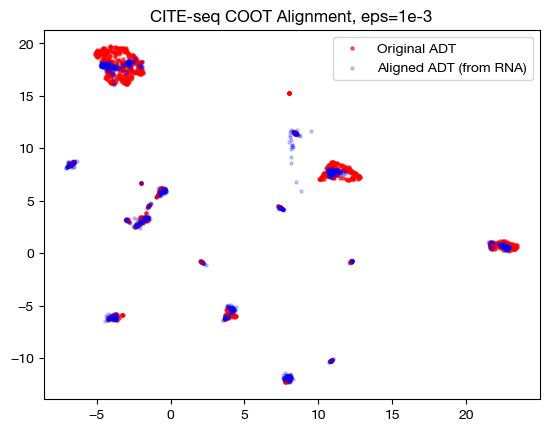

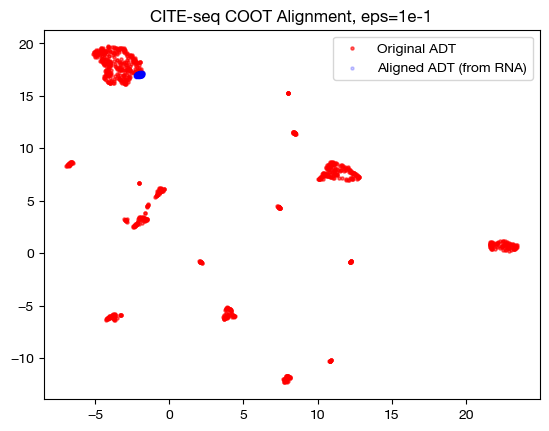

In [18]:
for aligned_rna, size in [(aligned_rna_sm, 'eps=1e-4'), (aligned_rna_med, 'eps=1e-3'), (aligned_rna_lg, 'eps=1e-1')]:    

    aligned_rna_um=adt_um.transform(aligned_rna.numpy())

    plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
    plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
    plt.legend()
    plt.title("CITE-seq COOT Alignment, {0}".format(size))
    plt.show()

Notice how, with the very small value for $\epsilon$, we get something closer to a 1-1 mapping in the UMAP; however, it seems like it may be "overfit" with the way the data groups into very small, separated clusters. On the other hand, notice that with the large value for $\epsilon$, we get no such 1-1 alignment. In fact, if we look at its PCA:

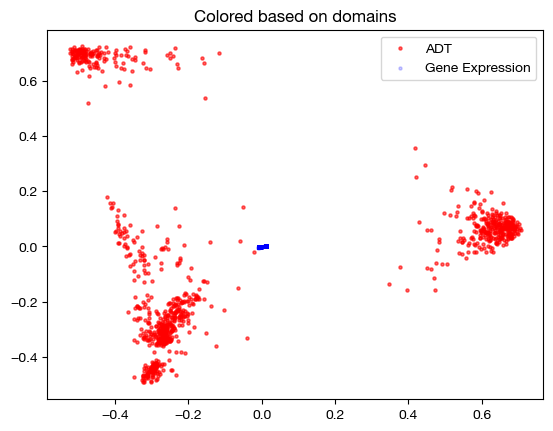

In [19]:
aligned_rna_pca=adt_pca.transform(aligned_rna.numpy())

plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5, alpha=0.6, label="ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=5, alpha=0.2, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

We can see that the gene expression data all gets projected near the origin on the PCA graph of the original ADT data – this indicates that the projection is getting closer to a weighted average of all samples in the original ADT domain, applied to each sample in the gene expression domain (low variance in aligned values). This result is exactly what we would expect, given a very dense sample coupling matrix.

From here, we will quickly examine joint versus independent entropic regularization. In the joint case, we entropically regularize by adding a term to the cost function that measures the joint entropy of the sample AND feature coupling matrices. However, in the independent case (default, which we have been implicitly using so far), we add two terms to the cost function; one that measures the entropy of the sample coupling matrix, and one that measures the entropy of the feature coupling matrix. If you are trying to get a more sparse coupling matrix of either the features or the samples in the hopes of getting something closer to a map, you might use independent entropic regularization and lower the $\epsilon$ value for the relevant entropy term.

To specify the type of entropic regularization you are using, pass in 'joint' or 'independent' to the entropic_mode parameter of the coot/ucoot functions. If you use joint regularization, only the first term of your $\epsilon$ tuple will be used in solving. Let's make one comparison of joint vs. independent entropic regulariztion:

In [20]:
pi_samp_ind, _, pi_feat_ind = scot.coot(rna, adt, eps=1e-3, entropic_mode="independent", verbose=False)

pi_samp_jnt, _, pi_feat_jnt = scot.coot(rna, adt, eps=1e-3, entropic_mode="joint", verbose=False)

We can look at the resulting coupling matrices:

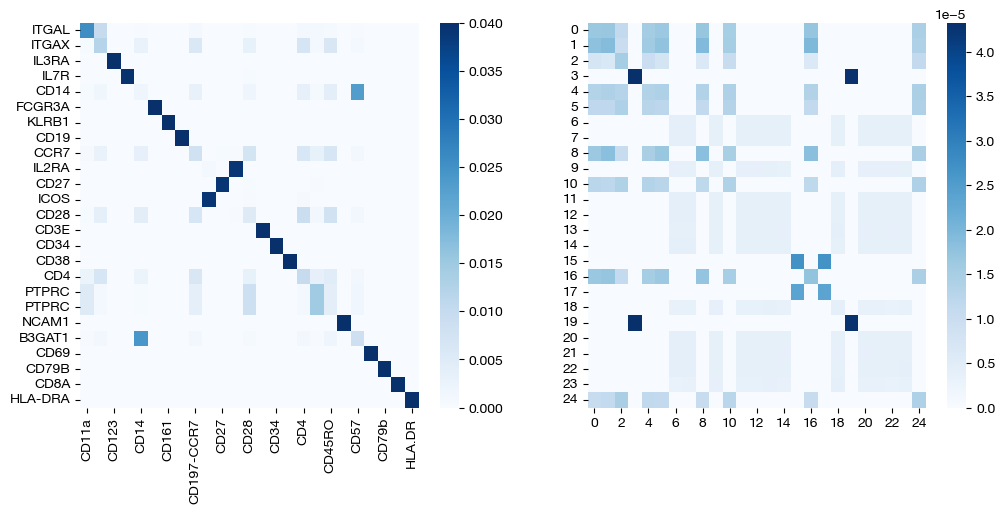

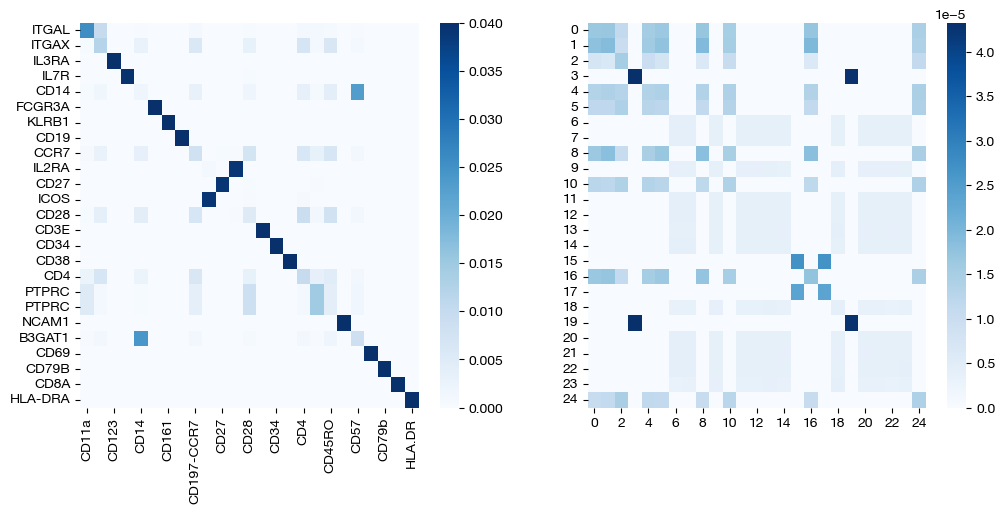

In [21]:
for pi_feat, pi_samp, mode in [(pi_feat_ind, pi_samp_ind, 'independent'), (pi_feat_jnt, pi_samp_jnt, 'joint')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), ax=ax1, cmap='Blues')
    
    # again, just a corner to get a sense
    sns.heatmap(pi_samp[0:25,0:25], cmap='Blues')
    plt.show()

Note that these are the same, considering that we didn't let the $\epsilon$ values differ in the independent case. Let's try doing so, and comparing again:

In [116]:
pi_samp_ind, _, pi_feat_ind = scot.coot(rna, adt, eps=(1e-3, 1), entropic_mode="independent", verbose=False)

pi_samp_jnt, _, pi_feat_jnt = scot.coot(rna, adt, entropic_mode="joint", verbose=False)

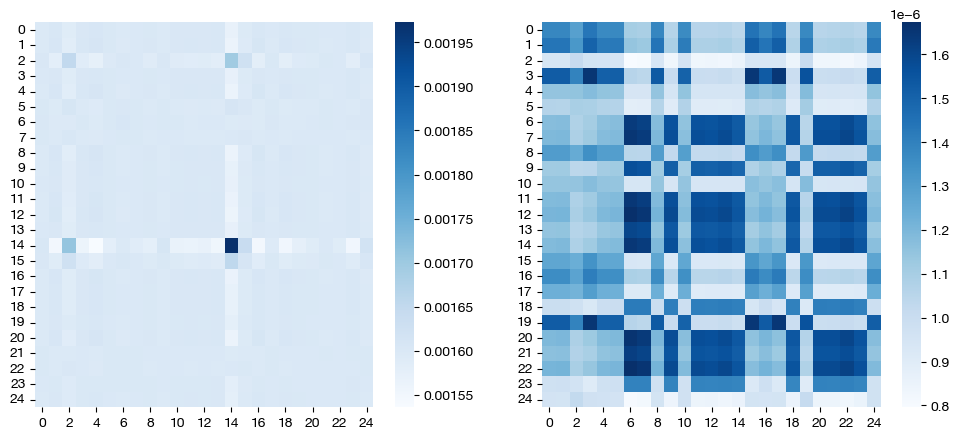

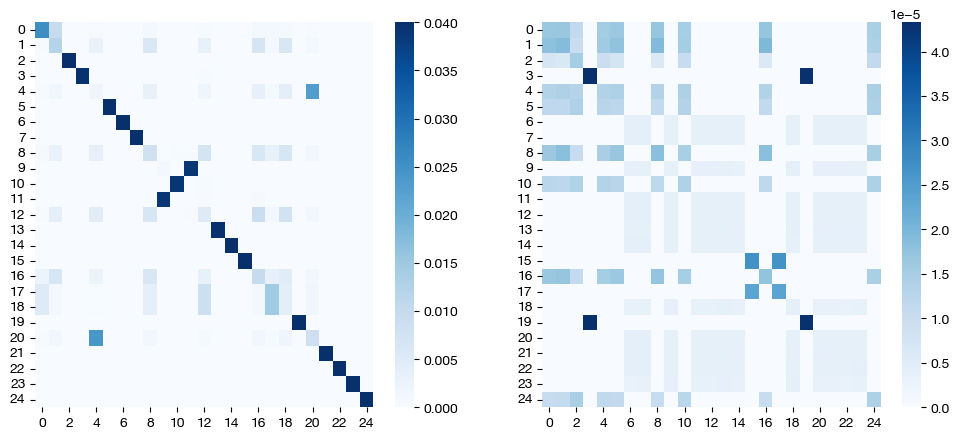

In [117]:
for pi_feat, pi_samp, mode in [(pi_feat_ind, pi_samp_ind, 'independent'), (pi_feat_jnt, pi_samp_jnt, 'joint')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pi_feat, ax=ax1, cmap='Blues')
    sns.heatmap(pi_samp[0:25,0:25], cmap='Blues')
    plt.show()

As expected, in the independent case, we get a dense feature coupling matrix (we gave $\epsilon_f = 0.1$, a relatively high value). We conclude that we can leverage independent entropic regularization when we want to favor sparsity/density in one matrix over the other; however, in most cases, we recommend sticking to a singular $\epsilon$ value, with either joint or independent regularization. Tuning the extra hyperparameter for optimized performance in the independent case is unlikely to yield more meaningful results. Since the matrices are co-dependent during optimization, the density in one coupling matrix can sometimes lead to different results in the other, as seen above (we also have a somewhat dense sample coupling matrix).

### Marginal Relaxation

From here, let's examine the $\rho$ hyperparameter. So far, we have been using the coot solver (with the exception of our last example), which does not allow for marginal relaxation via the $\rho$ hyperparameters. In the case of UCOOT (ucoot function), $\rho$ is a tuple of hyperparameters, one that relates to the projected domain ($\rho_y$) and one that relates to the target domain ($\rho_x$). Considering that our optimal transport problem seeks to create two matrices that define a way to transport the mass from

1. (sample coupling matrix) A probability distribution whose outcomes are samples in X to a probability distribution whose outcomes are samples in Y, and

2. (feature coupling matrix) A probability distribution whose outcomes are features in X to a probability distribution whose features are samples in Y,

we should constrain the marginal distributions of each coupling matrix to equal the distributions referenced in 1. and 2. respectively. In fact, in the original development of this algorithm (COOT), this criterion was an additional constraint in the process of minimizing transport cost through modification of a coupling matrix. However, in UCOOT, rather than forcing this constraint upon the objective function, we add two new terms to the cost function, each of which is multiplied by their respective hyperparameters, $\rho_x$ and $\rho_y$. These terms measure the distance between the true distributions of (for example) X's samples and features, which UCOOT defaults as uniform, and the marginal distributions of the sample and feature coupling matrices. In particular, these terms utilize KL divergence to achieve such a measurement. $\rho_x$ determines the weight of the distance between the two X-related true (desired) and marginal distributions, while $\rho_y$ does the equivalent for Y.

With this intuition in mind, we can see that increasing either $\rho$ parameter will lead the resulting coupling matrices to have marginals closer to the initial distributions of the samples and features of its respective dataset. Again, UCOOT's default initial distributions are both uniform. By decreasing $\rho$, however, we allow the coupling matrices to deviate further from uniform distributions, allowing either samples or features in X and Y to transport more mass relative to other samples or features. This can account for disproportionate cell type representation on the sample side, as one application.

Let's try modifying $\rho$ in two different cases: one where there is no disproportionate representation of features and samples, and one where there is.

First, we have the same balanced problem from earlier; this time, we significantly relax the uniform marginal constraint (which was enforced in earlier parts of this tutorial with $\rho$=infinity, our default):

In [34]:
pi_samp, _, pi_feat = scot.ucoot(rna, adt, eps=1e-3, rho=(0.1,0.1), verbose=False)
aligned_rna = get_barycentre(adt, pi_samp)
aligned_rna.numpy().shape

(1000, 25)

Now, we can score this case:

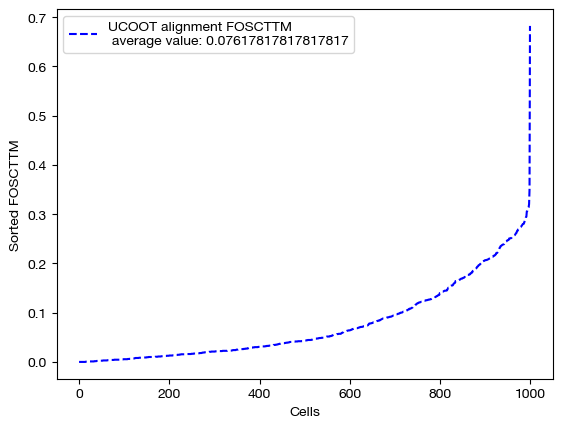

In [35]:
fracs = FOSCTTM(adt, aligned_rna.numpy())
legend_label="UCOOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

And visualize it:

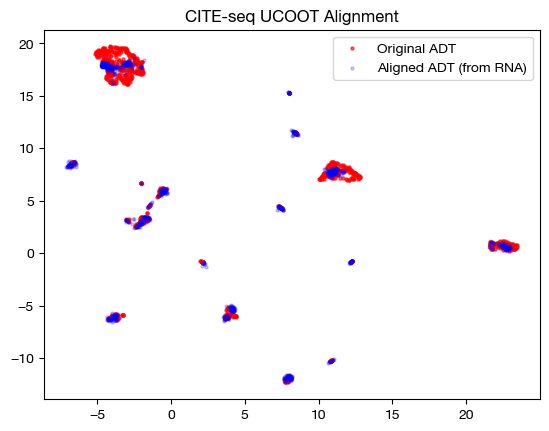

In [36]:
# fit on original two components
original_adt_um=adt_um.transform(adt)
aligned_rna_um=adt_um.transform(aligned_rna.numpy())

plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq UCOOT Alignment")
plt.show()

Finally, we can look at the feature coupling matrix: this is where we start to see the effects of $\rho$.

Row Sum:  tensor([0.0383, 0.0388, 0.0389, 0.0395, 0.0388, 0.0397, 0.0391, 0.0384, 0.0389,
        0.0378, 0.0390, 0.0391, 0.0391, 0.0393, 0.0390, 0.0388, 0.0390, 0.0392,
        0.0392, 0.0392, 0.0387, 0.0389, 0.0393, 0.0390, 0.0372])
Column Sum:  tensor([0.0355, 0.0401, 0.0389, 0.0392, 0.0411, 0.0397, 0.0391, 0.0384, 0.0392,
        0.0377, 0.0387, 0.0395, 0.0391, 0.0395, 0.0390, 0.0388, 0.0404, 0.0355,
        0.0405, 0.0392, 0.0384, 0.0389, 0.0393, 0.0390, 0.0371])


<Axes: >

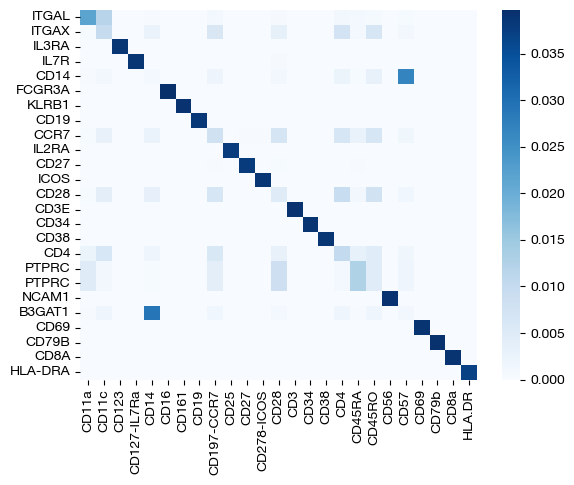

In [37]:
print("Row Sum: ", torch.sum(pi_feat, axis=1))
print("Column Sum: ", torch.sum(pi_feat, axis=0))
sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), cmap='Blues')

Before, we did not see any disparity in color at this level of $\epsilon$; we saw what was essentially a 1-1 mapping, at least for features. Now, we can see that we no longer have this result. In fact, the sum of values in each row and column is no longer uniform, meaning some features/samples transport less mass than others. This result is exactly what we would expect when modifying $\rho$. Modifying $\rho$ can be even more useful in a disproportionate case; for example, if we restrict the genes present in our RNA-seq domain down to a subset of 15, we want the antibodies associated with the 15 genes we choose to transport more mass, in theory. Let's see if this result occurs with UCOOT where we unbalance both domains (although, we expect each of the 15 RNA-seq features to contribute uniformly, assuming there are no off-diagonal interactions in the ground truth biology).

In [118]:
rna_subset = rna.iloc[:, :15]

pi_samp, _, pi_feat = scot.ucoot(rna_subset, adt, eps=2e-3, rho=(0.1, 0.1), verbose=False)

aligned_rna = get_barycentre(adt, pi_samp)
aligned_rna.numpy().shape

(1000, 25)

We can score, visualize, and look at the feature coupling matrix now in this case:

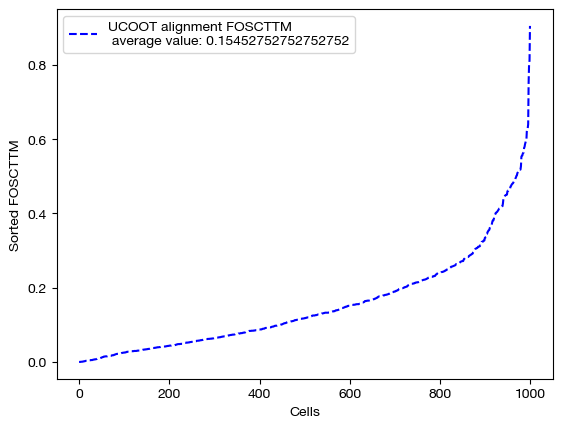

In [119]:
fracs = FOSCTTM(adt, aligned_rna.numpy())
legend_label="UCOOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

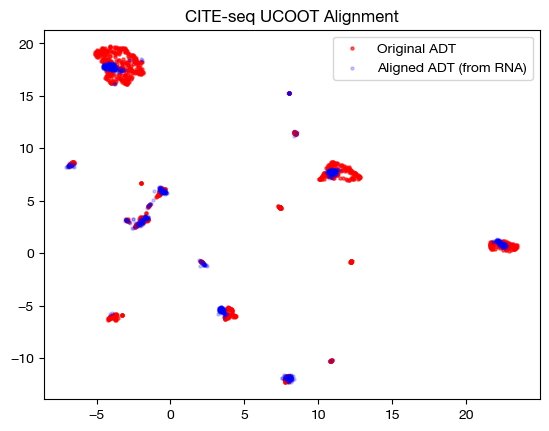

In [120]:
# fit on original two components
original_adt_um=adt_um.transform(adt)
aligned_rna_um=adt_um.transform(aligned_rna.numpy())

plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
plt.legend()
plt.title("CITE-seq UCOOT Alignment")
plt.show()

<Axes: >

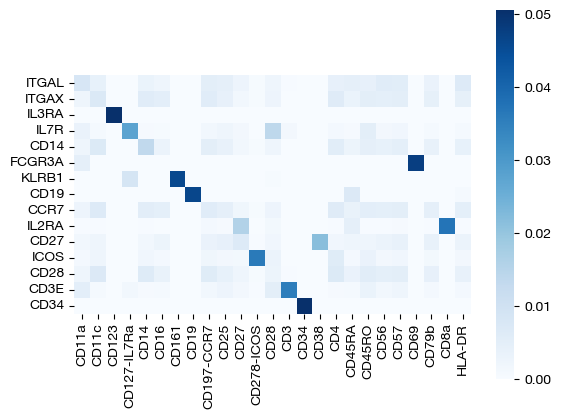

In [121]:
sns.heatmap(pd.DataFrame(pi_feat, index=rna_subset.columns, columns=adt.columns), cmap='Blues', square=True)

Desipte subsetting out RNA-seq features, we still recover most of the correct feature diagonal! We can look at the row and column sums of the feature matrix to get a sense for how unbalancing helped:

In [126]:
# normalized row sums
torch.sum(pi_feat, axis=1)/torch.mean(torch.sum(pi_feat, axis=1))

tensor([1.0853, 1.1048, 0.8044, 1.0672, 1.1036, 0.8349, 0.8820, 0.8609, 1.1078,
        1.0234, 1.0750, 1.0710, 1.1099, 1.0640, 0.8058])

For the row sums, we can see that most of our gene subset contributes uniformly.

In [129]:
# normalized column sums for first 15, second 10 ADT features
torch.mean((torch.sum(pi_feat, axis=0)/torch.mean(torch.sum(pi_feat, axis=0)))[:15]), torch.mean((torch.sum(pi_feat, axis=0)/torch.mean(torch.sum(pi_feat, axis=0)))[15:]), 

(tensor(1.0504), tensor(0.9245))

However, we can see that the first 15 columns (ADT features), which have ground truth relationships with our row variables, contribute more mass on average than the second 10 columns, whose relationships we omitted.

```{tip}
The logic we have examined in this section can also be applied to sample unbalancing; see our final section in the UGW tutorial for a short experiment. In addition, sample unbalancing can be very useful in the case that there is disproportionate cell type representation in a separately assayed pair of datasets.
```

### Conclusion

Hopefully, this explanation of the parameters of UCOOT has helped develop some intuition for how to tune UCOOT for your specific needs. To get more information on UCOOT, visit the tutorial that dives into how to use prior knowledge to aid your alignment (D and alpha hyperparameters, as well as other initializations). Once you read that, you can move on to our AGW tutorial.

Citations:

Quang Huy Tran, Hicham Janati, Nicolas Courty, Rémi Flamary, Ievgen Redko, Pinar Demetci and Ritambhara Singh. Unbalanced CO-Optimal Transport. arXiv, stat.ML, 2023.